1. Import Liblary

In [2]:
pip install tensorflow keras numpy pandas tqdm scikit-learn matplotlib seaborn pillow opencv-python ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from ultralytics import YOLO
import numpy as np
import zipfile
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2. Define fungsi untuk menampilkan contoh Training Image

In [4]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

3. Define fungsi untuk print text dalam RGB dan Background Colors

In [5]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #mencetak text_msg dalam warna latar depan yang ditentukan oleh fore_tupple dengan latar belakang yang ditentukan oleh back_tupple
    #text_msg adalah teks, fore_tupple adalah tupple warna latar depan (r,g,b), back_tupple adalah tupple latar belakang (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # mengembalikan warna cetak default menjadi hitam kembali
    return

4. Define subclass dari Keras callbacks untuk mengontrol Learning Rate dan print training data dalam format spreadsheet. Callback disini juga berfungsi untuk menanyakan secara berkala apakah lanjut training selama N epoch atau Halt (berhenti)

In [6]:
class LRA(Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        v_acc = logs.get('val_accuracy')

        if v_loss < 0.05 and v_acc > 0.95:
            msg = f'Pelatihan dihentikan karena kinerja sudah cukup baik di epoch {epoch+1}.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        elif self.stop_count > self.stop_patience - 1:
            msg = f'Pelatihan dihentikan setelah {self.stop_patience} pengurangan LR tanpa perbaikan.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        else:
            # Early stopping logic and adjustments based on learning rate
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.stop_count = 0
            else:
                self.stop_count += 1

            if self.stop_count >= self.patience:
                new_lr = self.initial_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                msg = f'Learning rate dikurangi menjadi {new_lr} pada epoch {epoch+1}.'
                self.print_in_color(msg, (255, 255, 255), (255, 0, 0))
                self.stop_count = 0
                self.count += 1

                if self.count >= self.dwell:
                    msg = f'Pembelajaran berhenti setelah {self.dwell} penurunan learning rate.'
                    self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
                    self.model.stop_training = True

            # Ask to continue training after specified epochs
            if (epoch + 1) % self.ask_epoch == 0:
                user_input = input(f"Apakah Anda ingin melanjutkan pelatihan setelah epoch {epoch+1}? (y/n): ")
                if user_input.lower() == 'n':
                    self.model.stop_training = True

    # Helper function to print colored messages
    def print_in_color(self, text, text_color, bg_color):
        print(f"\033[38;2;{text_color[0]};{text_color[1]};{text_color[2]}m\033[48;2;{bg_color[0]};{bg_color[1]};{bg_color[2]}m{text}\033[0m")


5. Define fungsi untuk plot training data

In [7]:
def tr_plot(tr_data, start_epoch):
    # Mengambil data dari riwayat pelatihan
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    # Menentukan jumlah epoch yang telah berjalan
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    
    # Menemukan epoch dengan loss validasi terkecil dan akurasi validasi terbesar
    index_loss = np.argmin(vloss)  # Epoch dengan validasi loss terkecil
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # Epoch dengan akurasi validasi tertinggi
    acc_highest = vacc[index_acc]
    
    # Menyiapkan label untuk titik terbaik
    sc_label = 'Best epoch (loss) = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch (accuracy) = ' + str(index_acc + 1 + start_epoch)
    
    # Membuat subplot untuk dua grafik: loss dan akurasi
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot untuk Training dan Validation Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot untuk Training dan Validation Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Layout yang rapi untuk plot
    plt.tight_layout()
    plt.show()


6. Define fungsi untuk membuat confusion matrix dan classification report

In [8]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    # Membuat kamus untuk memetakan indeks kelas integer ke nama kelas
    for key, value in class_dict.items():
        new_dict[value] = key  # {indeks kelas integer: nama kelas string}
    
    # Simpan kamus kelas ke file teks di direktori simpan
    classes = list(new_dict.values())  # Daftar nama kelas
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # Label adalah nilai integer
        if pred_index != true_index:  # Terjadi kesalahan klasifikasi
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        y_pred.append(pred_index)

    # Cetak rincian kesalahan jika ada kesalahan
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Nama File', 'Kelas Prediksi', 'Kelas Sebenarnya', 'Probabilitas')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'Dengan akurasi 100%, tidak ada kesalahan yang perlu dicetak'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    # Plot kesalahan berdasarkan kelas
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # Daftar yang berisi jumlah kesalahan per kelas
                plot_class.append(value)  # Menyimpan kelas
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Kesalahan Berdasarkan Kelas pada Set Pengujian')
        plt.show()

    # Membuat confusion matrix dan classification report
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # Menghasilkan confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        fig_width = 8 if length < 8 else int(length * 0.5)
        fig_height = 8 if length < 8 else int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Prediksi")
        plt.ylabel("Sebenarnya")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Laporan Klasifikasi:\n----------------------\n", clr)


7. Define fungsi untuk menyimpan model dan associated class_dict.csv file

In [9]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # Pertama, simpan model
    save_id = str(model_name + '-' + subject + '-' + str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color('Model disimpan sebagai ' + model_save_loc, (0, 255, 0), (55, 65, 80))

    # Sekarang buat class_df dan konversikan ke file CSV
    class_dict = generator.class_indices
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    
    # Membuat DataFrame dengan informasi kelas
    Index_series = pd.Series(list(class_dict.values()), name='class_index')
    Class_series = pd.Series(list(class_dict.keys()), name='class')
    Height_series = pd.Series(height, name='height')
    Width_series = pd.Series(width, name='width')
    Scale_series = pd.Series(scale, name='scale by')
    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    
    # Menyimpan DataFrame ke file CSV
    csv_name = 'Eye_Diseases.csv'
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color('File CSV kelas disimpan sebagai ' + csv_save_loc, (0, 255, 0), (55, 65, 80))
    
    return model_save_loc, csv_save_loc


8. Definisikan fungsi untuk menggunakan model terlatih untuk prediksi

In [10]:
def classify(sdir, csv_path, model_path, crop_image=False):
    # Membaca file CSV
    class_df = pd.read_csv(csv_path)
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_height, img_width)
    scale = class_df['scale by'].iloc[0]
    
    # Menentukan skala
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
        print(s1, s2)
    
    # Membaca daftar file citra dari direktori
    path_list = []
    paths = os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    
    print('Model sedang dimuat - ini akan memakan waktu sekitar 10 detik')
    model = load_model(model_path)
    
    image_count = len(path_list)
    index_list = []
    prob_list = []
    cropped_image_list = []
    good_image_count = 0
    
    for i in range(image_count):
        img = plt.imread(path_list[i])
        
        # Memangkas citra jika crop_image diaktifkan
        if crop_image:
            status, img = crop(img)
        else:
            status = True
        
        if status:
            good_image_count += 1
            img = cv2.resize(img, img_size)
            print('Citra ukuran:', img.shape)
            cropped_image_list.append(img)
            img = img * s2 - s1
            img = np.expand_dims(img, axis=0)
            p = np.squeeze(model.predict(img))
            index = np.argmax(p)
            print(index)
            prob = p[index]
            index_list.append(index)
            prob_list.append(prob)
    
    # Menghasilkan hasil untuk satu citra yang baik
    if good_image_count == 1:
        class_name = class_df['class'].iloc[index_list[0]]
        probability = prob_list[0]
        img = cropped_image_list[0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    
    # Jika tidak ada citra yang baik
    elif good_image_count == 0:
        return None, None
    
    # Menghitung kelas yang paling sering muncul
    most = 0
    for i in range(len(index_list)-1):
        key = index_list[i]
        keycount = 0
        for j in range(i+1, len(index_list)):
            nkey = index_list[j]
            if nkey == key:
                keycount += 1
        if keycount > most:
            most = keycount
            isave = i
    
    best_index = index_list[isave]
    psum = 0
    bestsum = 0
    for i in range(len(index_list)):
        psum += prob_list[i]
        if index_list[i] == best_index:
            bestsum += prob_list[i]
    
    img = cropped_image_list[isave] / 255
    class_name = class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    
    return class_name, bestsum / image_count


9.  Import Citra

In [11]:
# Path ke file ZIP
zip_file_path = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\archive.zip"  # Gunakan 'r' untuk raw string agar path Windows diterima

# Lokasi untuk ekstraksi file
extract_to = "Eye_Diseases"  # Direktori tempat file akan diekstrak

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)  # Ekstrak semua file ke folder 'extracted_data'

# Dapatkan daftar file dalam folder ekstraksi
extracted_files = []
for root, _, files in os.walk(extract_to):
    for file in files:
        extracted_files.append(os.path.join(root, file))  # Simpan path lengkap setiap file

print("File yang diekstrak:")
for file in extracted_files:
    print(file)

# Temukan dan baca semua file CSV
csv_files = [file for file in extracted_files if file.endswith(".csv")]

if csv_files:
    print("\nFile CSV yang ditemukan:")
    for csv_file in csv_files:
        print(csv_file)
        try:
            # Baca setiap file CSV
            data = pd.read_csv(csv_file)
            print(f"\nData dari file {os.path.basename(csv_file)}:")
            print(data.head())  # Tampilkan 5 baris pertama
        except Exception as e:
            print(f"Error membaca file {csv_file}: {e}")
else:
    print("Tidak ada file CSV yang ditemukan di dalam ZIP.")


File yang diekstrak:
Eye_Diseases\dataset\cataract\0_left.jpg
Eye_Diseases\dataset\cataract\103_left.jpg
Eye_Diseases\dataset\cataract\1062_right.jpg
Eye_Diseases\dataset\cataract\1083_left.jpg
Eye_Diseases\dataset\cataract\1084_right.jpg
Eye_Diseases\dataset\cataract\1102_left.jpg
Eye_Diseases\dataset\cataract\1102_right.jpg
Eye_Diseases\dataset\cataract\1115_left.jpg
Eye_Diseases\dataset\cataract\1126_right.jpg
Eye_Diseases\dataset\cataract\112_right.jpg
Eye_Diseases\dataset\cataract\1144_left.jpg
Eye_Diseases\dataset\cataract\1144_right.jpg
Eye_Diseases\dataset\cataract\1164_left.jpg
Eye_Diseases\dataset\cataract\1167_right.jpg
Eye_Diseases\dataset\cataract\119_left.jpg
Eye_Diseases\dataset\cataract\1285_left.jpg
Eye_Diseases\dataset\cataract\1415_left.jpg
Eye_Diseases\dataset\cataract\1415_right.jpg
Eye_Diseases\dataset\cataract\1435_left.jpg
Eye_Diseases\dataset\cataract\1444_left.jpg
Eye_Diseases\dataset\cataract\1452_left.jpg
Eye_Diseases\dataset\cataract\1454_right.jpg
Eye_Dise

(256, 256, 3)


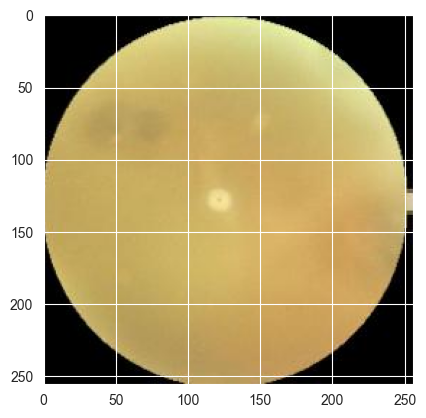

In [12]:
import matplotlib.pyplot as plt # Add this line at the beginning of the cell
fpath=r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset\cataract\_0_4015166.jpg'
img=plt.imread(fpath) # Now 'plt' is recognized
print (img.shape)
plt.imshow(img)

11. Iterate direktori data dan membuat data frame kedalam filepaths dan labels

In [13]:
# Direktori dataset
sdir = r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset'

# Membuat daftar file paths dan label
classlist = os.listdir(sdir)
filepaths = []
labels = []

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):  # Pastikan hanya folder yang diproses
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

# Membuat dataframe dari filepaths dan labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Membagi data ke dalam train, validation, dan test set
trsplit = 0.9  # Proporsi data training
vsplit = 0.05  # Proporsi data validasi
dsplit = vsplit / (1 - trsplit)  # Proporsi data validasi terhadap sisa data

train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)

# Menampilkan informasi jumlah data
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Menampilkan distribusi label pada training set
balance = train_df['labels'].value_counts()
print("\nDistribusi label di training set:")
for label, count in balance.items():
    print(f"{label}: {count}")


train_df length: 3795  test_df length: 211  valid_df length: 211

Distribusi label di training set:
diabetic_retinopathy: 992
normal: 961
cataract: 933
glaucoma: 909


12. Batasi sampel data di setiap kelas menjadi 906 untuk seimbang

In [14]:
# 1. Membuat DataFrame yang seimbang
sample_list = []
max_size = 906  # Target jumlah per kelas
min_size = 0  # Minimal jumlah per kelas
groups = train_df.groupby('labels')  # Kelompokkan data berdasarkan label

for label in train_df['labels'].unique():
    group = groups.get_group(label)
    sample_count = len(group)
    
    if sample_count > max_size:
        # Ambil sampel acak jika jumlah data lebih dari max_size
        samples = group.sample(max_size, replace=False, random_state=123).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count >= min_size:
        # Gunakan semua data jika jumlahnya kurang dari max_size
        sample_list.append(group)

# Gabungkan kembali semua sampel menjadi DataFrame yang seimbang
balanced_df = pd.concat(sample_list, axis=0).reset_index(drop=True)

# Menampilkan distribusi label setelah balancing
balance = list(balanced_df['labels'].value_counts())
print("Distribusi data setelah balancing:", balance)

Distribusi data setelah balancing: [906, 906, 906, 906]


13. Membuat train, test, valid generators

In [15]:

# 2. Membagi dataset menjadi train, validation, dan test
from sklearn.model_selection import train_test_split

# 80% untuk training-validation dan 20% untuk testing
train_val_df, test_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df['labels'], random_state=123
)

# 20% dari data train_val untuk validation
train_df, valid_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df['labels'], random_state=123
)

print("Distribusi data training:", train_df['labels'].value_counts())
print("Distribusi data validation:", valid_df['labels'].value_counts())
print("Distribusi data testing:", test_df['labels'].value_counts())

# 3. Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.0)  # Tidak gunakan validation split karena sudah dipisah manual

    generator = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
    )

    return generator

# 4. Membuat generators untuk training, validation, dan testing
train_gen = create_generators(train_df, 'train_directory')
valid_gen = create_generators(valid_df, 'train_directory')
test_gen = create_generators(test_df, 'train_directory')

# 5. Informasi tambahan
classes = list(train_gen.class_indices.keys())  # Mendapatkan daftar kelas
class_count = len(classes)  # Mendapatkan jumlah kelas

train_steps = np.ceil(len(train_gen.labels) / train_gen.batch_size)  # Langkah per epoch untuk training
valid_steps = np.ceil(len(valid_gen.labels) / valid_gen.batch_size)  # Langkah per epoch untuk validasi
test_steps = np.ceil(len(test_gen.labels) / test_gen.batch_size)  # Langkah untuk testing

# Output informasi
print("Classes:", classes)
print("Number of classes:", class_count)
print("Train steps per epoch:", train_steps)
print("Validation steps per epoch:", valid_steps)
print("Test steps:", test_steps)

Distribusi data training: labels
cataract                580
normal                  580
diabetic_retinopathy    580
glaucoma                579
Name: count, dtype: int64
Distribusi data validation: labels
diabetic_retinopathy    145
normal                  145
glaucoma                145
cataract                145
Name: count, dtype: int64
Distribusi data testing: labels
glaucoma                182
cataract                181
normal                  181
diabetic_retinopathy    181
Name: count, dtype: int64
Found 2319 validated image filenames belonging to 4 classes.
Found 580 validated image filenames belonging to 4 classes.
Found 725 validated image filenames belonging to 4 classes.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of classes: 4
Train steps per epoch: 73.0
Validation steps per epoch: 19.0
Test steps: 23.0


14. Membuat fungsi untuk menampilkan beberapa sample citra dari penyakit mata

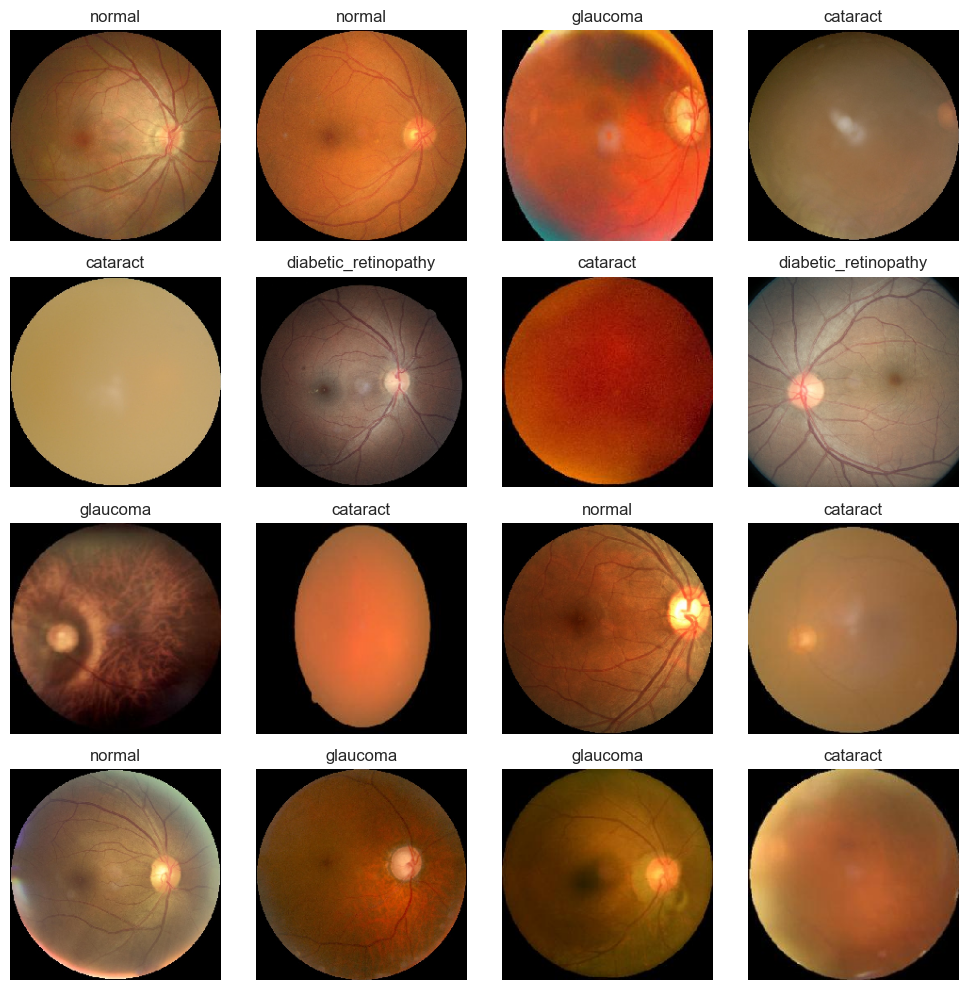

In [16]:
def show_image_samples(generator, num_samples=16):
    # Ambil satu batch dari generator
    images, labels = next(generator)

    # Batasi jumlah gambar sesuai num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Menentukan jumlah baris dan kolom untuk subplot
    cols = int(np.ceil(np.sqrt(num_samples)))
    rows = int(np.ceil(num_samples / cols))

    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        # Jika gambar sudah dinormalisasi (misalnya antara 0 dan 1), kembalikan ke rentang 0-255
        img = images[i]
        if img.min() >= 0 and img.max() <= 1:
            img = (img * 255).astype("uint8")
        plt.imshow(img)  # Pastikan tipe data sesuai untuk ditampilkan
        label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan sampel gambar
show_image_samples(train_gen)



15. Bangun model VGG-19

In [17]:
from tensorflow.keras.applications import VGG19

def build_vgg19_model(num_classes, img_shape=(224, 224, 3)):
    # Arsitektur VGG19 dengan penyesuaian
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    
    # Membekukan semua lapisan base model
    for layer in base_model.layers:
        layer.trainable = False

    # Menambahkan lapisan kustom
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(
        256,
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    )(x)
    x = Dropout(rate=0.45)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Membuat model
    model = Model(inputs=base_model.input, outputs=output)

    # Kompilasi model dengan Adamax
    model.compile(
        optimizer=Adamax(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Ringkasan model
num_classes = 4  # Misalnya 4 kelas untuk kasus Anda
model = build_vgg19_model(num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,158,788 (76.90 MB)

 Trainable params: 133,380 (521.02 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

16. Bangun model YOLOv8

In [55]:
def build_yolov8_model(dataset_dir):
    model = YOLO("yolov8n.pt")
    model.train(data=dataset_dir, epochs=50, imgsz=640)
    return model

17. Latih model dengan callbacks

In [22]:
# Import library
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir, batch_size=32, validation_split=0.2):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    train_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=batch_size, subset='training', class_mode='categorical'
    )

    valid_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=batch_size, subset='validation', class_mode='categorical'
    )

    return train_gen, valid_gen

# 2. Menyiapkan fungsi untuk membuat model VGG19
def build_vgg19_model(num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# 3. Fungsi untuk melatih model dengan callbacks
def train_model_with_callbacks(model, train_gen, valid_gen, epochs=50):
    train_steps = np.ceil(len(train_gen.labels) / train_gen.batch_size)
    validation_steps = np.ceil(len(valid_gen.labels) / valid_gen.batch_size)

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        steps_per_epoch=int(train_steps),
        validation_steps=int(validation_steps),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    return history

# 4. Fungsi untuk evaluasi pada test generator
def evaluate_model_on_test(model, test_gen):
    test_steps = np.ceil(len(test_gen.labels) / test_gen.batch_size)
    test_steps = int(test_steps)  # Convert to integer
    score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")
    return score


In [23]:

# 5. Menyesuaikan batch size agar langkah per epoch sesuai
train_batch_size = 42  # Disesuaikan agar langkah training = 73.0
valid_batch_size = 40  # Disesuaikan agar langkah validasi = 19.0
test_batch_size = 9    # Disesuaikan agar langkah pengujian = 23.0

# 6. Membuat generator
train_gen, valid_gen = create_generators(train_df, 'train_directory', batch_size=train_batch_size)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=test_batch_size,
    shuffle=False
)

# 7. Mendapatkan jumlah langkah per epoch
train_steps = np.ceil(len(train_gen.labels) / train_batch_size)
valid_steps = np.ceil(len(valid_gen.labels) / valid_batch_size)
test_steps = np.ceil(len(test_gen.labels) / test_batch_size)

# 8. Menampilkan informasi langkah
print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {valid_steps}")
print(f"Test steps: {test_steps}")

# 9. Menyiapkan optimizer
optimizer = Adam(learning_rate=0.0001)

# 10. Menyiapkan callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# 11. Membuat model VGG19
vgg_model = build_vgg19_model(num_classes=len(train_gen.class_indices))
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 12. Melatih model
history = train_model_with_callbacks(vgg_model, train_gen, valid_gen, epochs=50)

# 13. Evaluasi pada test generator
test_score = evaluate_model_on_test(vgg_model, test_gen)


Found 1856 validated image filenames belonging to 4 classes.
Found 463 validated image filenames belonging to 4 classes.
Found 725 validated image filenames belonging to 4 classes.
Train steps per epoch: 45.0
Validation steps per epoch: 12.0
Test steps: 81.0


c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 75s/step - accuracy: 0.4041 - loss: 1.5966  
Epoch 1: val_loss improved from inf to 1.31111, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4223s 93s/step - accuracy: 0.4063 - loss: 1.5901 - val_accuracy: 0.5054 - val_loss: 1.3111
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 64s/step - accuracy: 0.6638 - loss: 0.9096  
Epoch 2: val_loss improved from 1.31111 to 1.28142, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3486s 77s/step - accuracy: 0.6639 - loss: 0.9092 - val_accuracy: 0.3974 - val_loss: 1.2814
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.6599 - loss: 0.8685 
Epoch 3: val_loss improved from 1.28142 to 1.26338, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2350s 52s/step - accuracy: 0.6604 - loss: 0.8672 - val_accuracy: 0.4017 - val_loss: 1.2634
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.7015 - loss: 0.8042 
Epoch 4: val_loss improved from 1.26338 to 1.17609, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2085s 46s/step - accuracy: 0.7017 - loss: 0.8034 - val_accuracy: 0.4406 - val_loss: 1.1761
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.7413 - loss: 0.6885 
Epoch 5: val_loss improved from 1.17609 to 1.09922, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2084s 45s/step - accuracy: 0.7412 - loss: 0.6884 - val_accuracy: 0.4644 - val_loss: 1.0992
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.7446 - loss: 0.6957 
Epoch 6: val_loss improved from 1.09922 to 1.04854, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1985s 44s/step - accuracy: 0.7445 - loss: 0.6953 - val_accuracy: 0.4665 - val_loss: 1.0485
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.7676 - loss: 0.6415 
Epoch 7: val_loss improved from 1.04854 to 0.90712, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1825s 40s/step - accuracy: 0.7675 - loss: 0.6413 - val_accuracy: 0.5421 - val_loss: 0.9071
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.7743 - loss: 0.6052 
Epoch 8: val_loss improved from 0.90712 to 0.77489, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2729s 60s/step - accuracy: 0.7744 - loss: 0.6050 - val_accuracy: 0.6868 - val_loss: 0.7749
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - accuracy: 0.7761 - loss: 0.6042 
Epoch 9: val_loss improved from 0.77489 to 0.66897, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3088s 69s/step - accuracy: 0.7761 - loss: 0.6035 - val_accuracy: 0.7408 - val_loss: 0.6690
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - accuracy: 0.7634 - loss: 0.5817 
Epoch 10: val_loss improved from 0.66897 to 0.63475, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3351s 73s/step - accuracy: 0.7636 - loss: 0.5814 - val_accuracy: 0.7603 - val_loss: 0.6348
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - accuracy: 0.7708 - loss: 0.5888 
Epoch 11: val_loss improved from 0.63475 to 0.57350, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3050s 68s/step - accuracy: 0.7709 - loss: 0.5886 - val_accuracy: 0.8035 - val_loss: 0.5735
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8058 - loss: 0.5221 
Epoch 12: val_loss improved from 0.57350 to 0.50641, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1640s 36s/step - accuracy: 0.8055 - loss: 0.5226 - val_accuracy: 0.8013 - val_loss: 0.5064
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8012 - loss: 0.5341 
Epoch 13: val_loss improved from 0.50641 to 0.44255, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1595s 36s/step - accuracy: 0.8011 - loss: 0.5344 - val_accuracy: 0.8315 - val_loss: 0.4425
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8195 - loss: 0.4719 
Epoch 14: val_loss did not improve from 0.44255
45/45 ━━━━━━━━━━━━━━━━━━━━ 1600s 36s/step - accuracy: 0.8191 - loss: 0.4726 - val_accuracy: 0.8272 - val_loss: 0.4486
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8176 - loss: 0.4887 
Epoch 15: val_loss improved from 0.44255 to 0.42425, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1598s 36s/step - accuracy: 0.8173 - loss: 0.4895 - val_accuracy: 0.8380 - val_loss: 0.4242
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8199 - loss: 0.4809 
Epoch 16: val_loss improved from 0.42425 to 0.38689, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1591s 35s/step - accuracy: 0.8198 - loss: 0.4808 - val_accuracy: 0.8661 - val_loss: 0.3869
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8182 - loss: 0.4711 
Epoch 17: val_loss improved from 0.38689 to 0.37605, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1616s 36s/step - accuracy: 0.8181 - loss: 0.4716 - val_accuracy: 0.8596 - val_loss: 0.3761
Epoch 18/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7988 - loss: 0.5121 
Epoch 18: val_loss did not improve from 0.37605
45/45 ━━━━━━━━━━━━━━━━━━━━ 1594s 35s/step - accuracy: 0.7989 - loss: 0.5121 - val_accuracy: 0.8661 - val_loss: 0.3911
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8167 - loss: 0.4696 
Epoch 19: val_loss improved from 0.37605 to 0.37059, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1631s 36s/step - accuracy: 0.8165 - loss: 0.4700 - val_accuracy: 0.8639 - val_loss: 0.3706
Epoch 20/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8064 - loss: 0.4889 
Epoch 20: val_loss did not improve from 0.37059
45/45 ━━━━━━━━━━━━━━━━━━━━ 1601s 36s/step - accuracy: 0.8067 - loss: 0.4885 - val_accuracy: 0.8575 - val_loss: 0.3799
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8026 - loss: 0.5134 
Epoch 21: val_loss did not improve from 0.37059
45/45 ━━━━━━━━━━━━━━━━━━━━ 1672s 36s/step - accuracy: 0.8027 - loss: 0.5126 - val_accuracy: 0.8575 - val_loss: 0.3844
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8292 - loss: 0.4343 
Epoch 22: val_loss improved from 0.37059 to 0.36789, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1646s 36s/step - accuracy: 0.8291 - loss: 0.4342 - val_accuracy: 0.8661 - val_loss: 0.3679
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8391 - loss: 0.4032 
Epoch 23: val_loss did not improve from 0.36789
45/45 ━━━━━━━━━━━━━━━━━━━━ 1648s 36s/step - accuracy: 0.8389 - loss: 0.4040 - val_accuracy: 0.8639 - val_loss: 0.3716
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8143 - loss: 0.4585 
Epoch 24: val_loss did not improve from 0.36789
45/45 ━━━━━━━━━━━━━━━━━━━━ 1633s 36s/step - accuracy: 0.8146 - loss: 0.4584 - val_accuracy: 0.8510 - val_loss: 0.3956
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8235 - loss: 0.4760 
Epoch 25: val_loss improved from 0.36789 to 0.36670, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1629s 36s/step - accuracy: 0.8235 - loss: 0.4754 - val_accuracy: 0.8575 - val_loss: 0.3667
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.8376 - loss: 0.4195 
Epoch 26: val_loss did not improve from 0.36670
45/45 ━━━━━━━━━━━━━━━━━━━━ 1825s 40s/step - accuracy: 0.8374 - loss: 0.4197 - val_accuracy: 0.8596 - val_loss: 0.3690
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8174 - loss: 0.4468 
Epoch 27: val_loss did not improve from 0.36670
45/45 ━━━━━━━━━━━━━━━━━━━━ 1763s 39s/step - accuracy: 0.8176 - loss: 0.4466 - val_accuracy: 0.8423 - val_loss: 0.3809
Epoch 28/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8448 - loss: 0.4079 
Epoch 28: val_loss improved from 0.36670 to 0.34836, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1749s 39s/step - accuracy: 0.8447 - loss: 0.4081 - val_accuracy: 0.8683 - val_loss: 0.3484
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8382 - loss: 0.3994 
Epoch 29: val_loss did not improve from 0.34836
45/45 ━━━━━━━━━━━━━━━━━━━━ 1767s 39s/step - accuracy: 0.8379 - loss: 0.3998 - val_accuracy: 0.8639 - val_loss: 0.3507
Epoch 30/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8476 - loss: 0.4183 
Epoch 30: val_loss did not improve from 0.34836
45/45 ━━━━━━━━━━━━━━━━━━━━ 1763s 38s/step - accuracy: 0.8475 - loss: 0.4182 - val_accuracy: 0.8661 - val_loss: 0.3506
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8181 - loss: 0.4270 
Epoch 31: val_loss did not improve from 0.34836
45/45 ━━━━━━━━━━━━━━━━━━━━ 1743s 39s/step - accuracy: 0.8184 - loss: 0.4267 - val_accuracy: 0.8359 - val_loss: 0.4019
Epoch 32/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8247 - loss: 0.4165 
Epoch 32: val_loss did not improve from 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1736s 39s/step - accuracy: 0.8442 - loss: 0.3950 - val_accuracy: 0.8726 - val_loss: 0.3432
Epoch 34/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8500 - loss: 0.3753 
Epoch 34: val_loss did not improve from 0.34315
45/45 ━━━━━━━━━━━━━━━━━━━━ 1746s 39s/step - accuracy: 0.8500 - loss: 0.3759 - val_accuracy: 0.8747 - val_loss: 0.3450
Epoch 35/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8437 - loss: 0.4200 
Epoch 35: val_loss improved from 0.34315 to 0.33485, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1738s 39s/step - accuracy: 0.8436 - loss: 0.4197 - val_accuracy: 0.8812 - val_loss: 0.3348
Epoch 36/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8259 - loss: 0.4340 
Epoch 36: val_loss did not improve from 0.33485
45/45 ━━━━━━━━━━━━━━━━━━━━ 1742s 39s/step - accuracy: 0.8261 - loss: 0.4336 - val_accuracy: 0.8639 - val_loss: 0.3542
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.8234 - loss: 0.4212 
Epoch 37: val_loss did not improve from 0.33485
45/45 ━━━━━━━━━━━━━━━━━━━━ 1781s 40s/step - accuracy: 0.8236 - loss: 0.4208 - val_accuracy: 0.8618 - val_loss: 0.3507
Epoch 38/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8369 - loss: 0.4075 
Epoch 38: val_loss did not improve from 0.33485
45/45 ━━━━━━━━━━━━━━━━━━━━ 1770s 39s/step - accuracy: 0.8369 - loss: 0.4076 - val_accuracy: 0.8726 - val_loss: 0.3482
Epoch 39/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8500 - loss: 0.3839 
Epoch 39: val_loss improved from 0.33485

45/45 ━━━━━━━━━━━━━━━━━━━━ 1738s 39s/step - accuracy: 0.8501 - loss: 0.3838 - val_accuracy: 0.8769 - val_loss: 0.3295
Epoch 40/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8529 - loss: 0.3792 
Epoch 40: val_loss did not improve from 0.32945
45/45 ━━━━━━━━━━━━━━━━━━━━ 1752s 38s/step - accuracy: 0.8528 - loss: 0.3793 - val_accuracy: 0.8661 - val_loss: 0.3484
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8580 - loss: 0.3609 
Epoch 41: val_loss did not improve from 0.32945
45/45 ━━━━━━━━━━━━━━━━━━━━ 1723s 38s/step - accuracy: 0.8578 - loss: 0.3613 - val_accuracy: 0.8661 - val_loss: 0.3415
Epoch 42/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8558 - loss: 0.3793 
Epoch 42: val_loss did not improve from 0.32945
45/45 ━━━━━━━━━━━━━━━━━━━━ 1721s 38s/step - accuracy: 0.8559 - loss: 0.3793 - val_accuracy: 0.8553 - val_loss: 0.3996
Epoch 43/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8519 - loss: 0.3705 
Epoch 43: val_loss did not improve from 

In [24]:
# 9. Menyimpan model dan informasi kelas
def save_model(model, class_dict, model_path="model.h5", class_dict_path="class_indices.npy"):
    """Menyimpan model terlatih dan informasi kelas ke dalam file."""
    model.save(model_path)
    np.save(class_dict_path, class_dict)
    print(f"Model disimpan di {model_path}")
    print(f"Class indices disimpan di {class_dict_path}")

# Menyimpan model dan informasi kelas
save_model(vgg_model, train_gen.class_indices)


Model disimpan di model.h5
Class indices disimpan di class_indices.npy


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


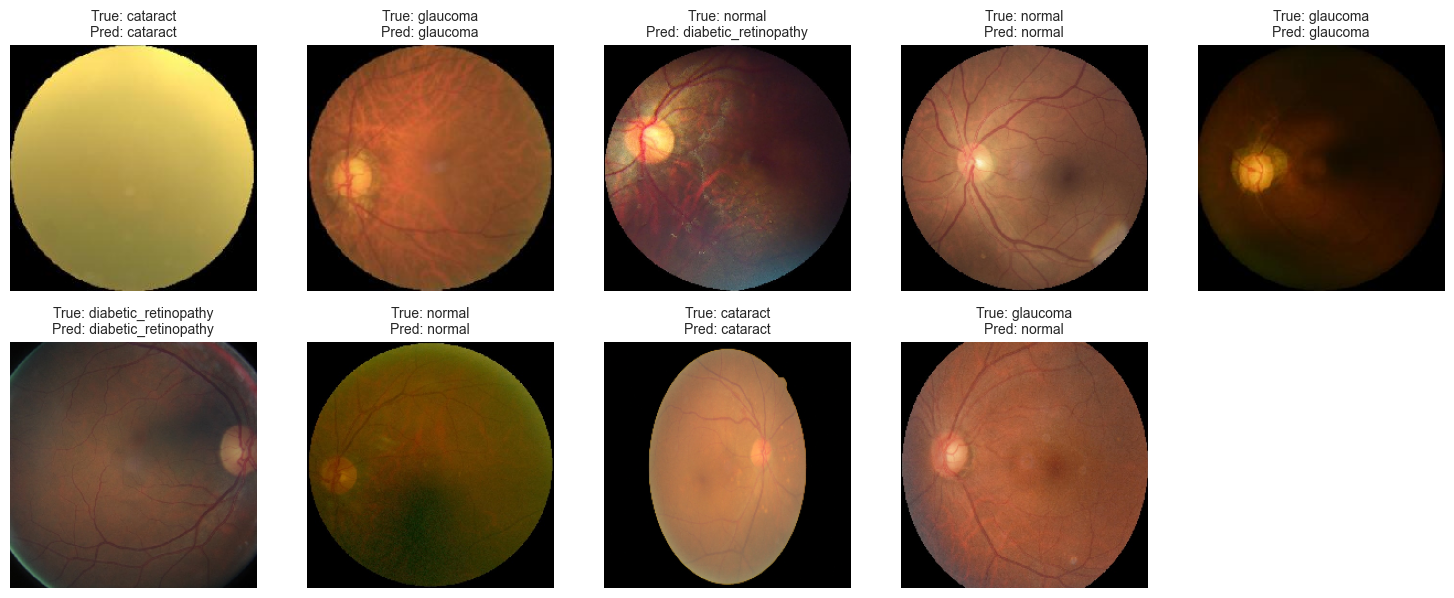

In [26]:
def visualize_predictions(model, test_gen, classes, num_images=10):
    """Fungsi untuk memvisualisasikan prediksi model pada dataset test."""
    test_gen.reset()
    x_batch, y_batch = next(test_gen)
    preds = model.predict(x_batch)
    
    # Tentukan jumlah gambar yang akan divisualisasikan
    num_images = min(num_images, x_batch.shape[0])
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_batch[i])
        true_label = classes[np.argmax(y_batch[i])]
        predicted_label = classes[np.argmax(preds[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Panggil fungsi visualize_predictions
visualize_predictions(vgg_model, test_gen, classes)


18. Evaluasi model pada test dataset kemudian menyimpan model ke h5 dan class csv

In [27]:
def evaluate_and_save_model(model, test_generator, model_path, class_dict_path):
    score = model.evaluate(test_generator)
    print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
    save_model(model, class_dict, model_path, class_dict_path)

19. Membuat prediksi pada test dataset kemudian generate confusion matrix dan classification report

In [40]:
def evaluate_and_save_model(model, test_generator, model_path="model.h5", class_dict_path="class_indices.npy"):
    """
    Fungsi untuk mengevaluasi model pada data test, menampilkan hasil evaluasi, 
    dan menyimpan model serta informasi kelas.

    Parameters:
        model (keras.Model): Model yang akan dievaluasi.
        test_generator (ImageDataGenerator): Generator data untuk testing.
        model_path (str): Lokasi penyimpanan file model (.h5).
        class_dict_path (str): Lokasi penyimpanan informasi kelas (.npy).
    """
    # Evaluasi model pada test generator
    score = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

    # Mendapatkan informasi kelas dari generator
    class_dict = test_generator.class_indices

    # Menyimpan model dan informasi kelas
    save_model(model, class_dict, model_path, class_dict_path)

def print_info(test_generator, predictions, print_code=0, save_dir=None, subject=None):
    """
    Fungsi untuk mencetak informasi tentang prediksi model.

    Parameters:
        test_generator (ImageDataGenerator): Generator data untuk testing.
        predictions (numpy.ndarray): Prediksi model pada data test.
        print_code (int): Kode untuk menentukan jenis informasi yang dicetak (default: 0).
        save_dir (str): Direktori untuk menyimpan hasil jika diperlukan.
        subject (str): Subjek data (misalnya nama dataset atau proyek).
    """
    # Mendapatkan kelas dari generator
    class_labels = list(test_generator.class_indices.keys())

    # Jika print_code = 0, tampilkan beberapa prediksi pertama
    if print_code == 0:
        print(f"\nPrediksi untuk dataset {subject}:\n")
        for i, pred in enumerate(predictions[:10]):  # Cetak 10 prediksi pertama
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            print(f"Data {i + 1}: True: {true_label}, Predicted: {predicted_label}")

    # Jika ada direktori penyimpanan, simpan hasil prediksi ke dalam file
    if save_dir is not None:
        results_path = f"{save_dir}/predictions.csv"
        results = []

        for i, pred in enumerate(predictions):
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            results.append({"True Label": true_label, "Predicted Label": predicted_label})

        # Simpan ke CSV
        pd.DataFrame(results).to_csv(results_path, index=False)
        print(f"\nHasil prediksi disimpan di {results_path}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 949s 12s/step


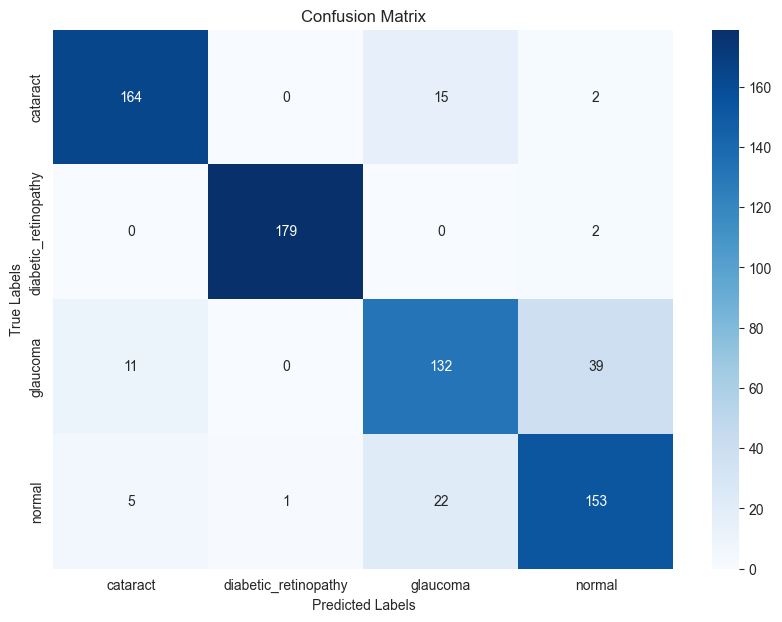

81/81 ━━━━━━━━━━━━━━━━━━━━ 886s 11s/step


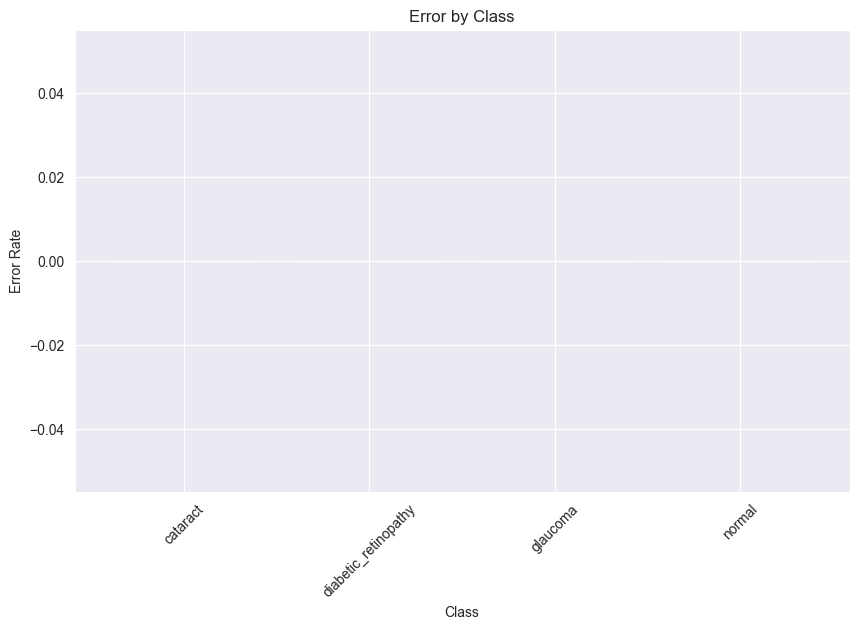

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

def plot_confusion_matrix(test_gen, model, class_labels):
    """
    Fungsi untuk menghasilkan dan memvisualisasikan confusion matrix.
    
    Parameters:
        test_gen (ImageDataGenerator): Generator data untuk testing.
        model (keras.Model): Model terlatih untuk evaluasi.
        class_labels (list): Daftar nama kelas.
    """
    # Prediksi pada test data
    preds = model.predict(test_gen, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = test_gen.classes

    # Membuat confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Menampilkan confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_error_by_class(test_gen, model, class_labels):
    """
    Fungsi untuk menghitung dan memvisualisasikan error by class.
    
    Parameters:
        test_gen (ImageDataGenerator): Generator data untuk testing.
        model (keras.Model): Model terlatih untuk evaluasi.
        class_labels (list): Daftar nama kelas.
    """
    # Prediksi pada test data
    preds = model.predict(test_gen, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = test_gen.classes

    # Menghitung error by class
    error_by_class = []
    for i in range(len(class_labels)):
        incorrect = np.sum((pred_labels == i) & (true_labels != i))  # Prediksi salah untuk kelas i
        total = np.sum(true_labels == i)  # Total data untuk kelas i
        error_rate = incorrect / total if total > 0 else 0
        error_by_class.append(error_rate)

    # Menampilkan error by class
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, error_by_class, color='red')
    plt.xlabel('Class')
    plt.ylabel('Error Rate')
    plt.title('Error by Class')
    plt.xticks(rotation=45)
    plt.show()

# 2. Menampilkan Confusion Matrix dan Error by Class
class_labels = list(test_gen.class_indices.keys())  # Daftar nama kelas

# Visualisasi confusion matrix
plot_confusion_matrix(test_gen, vgg_model, class_labels)

# Visualisasi error by class
plot_error_by_class(test_gen, vgg_model, class_labels)


20. Test Image Prediction Using YOLOv8

File class.names tidak ditemukan. Menggunakan daftar kelas bawaan.

image 1/1 D:\Project SCP Final\test_images\img_71_7.jpg: 640x640 1 person, 2149.1ms
Speed: 45.0ms preprocess, 2149.1ms inference, 197.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to c:\Users\RISKI ABDILAH\runs\detect\predict12


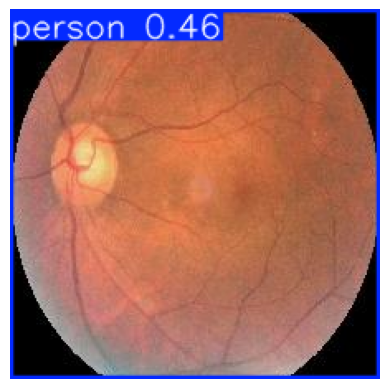

Predicted class: cataract, Confidence: 0.46
Hasil prediksi telah disimpan di folder: c:\Users\RISKI ABDILAH\runs\detect\predict12


In [59]:
# Path ke model YOLO
model_path = r'D:\Project SCP Final\yolov8n.pt'  # Ganti dengan model YOLO Anda yang sudah dilatih

# Coba memuat daftar kelas dari file class.names
class_names_path = 'class.names'  # Path ke file class.names
if os.path.exists(class_names_path):
    with open(class_names_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
else:
    # Jika file tidak ditemukan, gunakan daftar kelas langsung di kode
    print(f"File {class_names_path} tidak ditemukan. Menggunakan daftar kelas bawaan.")
    class_names = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal']

# Muat model YOLO yang sudah dilatih
model = YOLO(model_path)  # Path ke model yang sudah dilatih

# Path ke gambar sampel
sample_image = r"D:\Project SCP Final\test_images\img_71_7.jpg"  # Ganti dengan path gambar Anda

# Lakukan prediksi dengan threshold confidence lebih rendah (contoh: 0.25)
results = model.predict(source=sample_image, conf=0.25, save=True)  # Simpan hasil prediksi

# Visualisasi hasil prediksi
for result in results:
    annotated_image = result.plot()  # Gambar dengan anotasi
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Ekstraksi hasil prediksi dan cetak informasi
if len(results[0].boxes) > 0:  # Jika ada deteksi
    for box in results[0].boxes:  # Iterasi setiap bounding box
        predicted_class = int(box.cls[0].item())  # Indeks kelas prediksi
        confidence = box.conf[0].item()  # Nilai confidence

        # Validasi indeks kelas
        if 0 <= predicted_class < len(class_names):
            print(f"Predicted class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")
        else:
            print(f"Predicted class index {predicted_class} is out of range for the provided class names.")
else:
    print("No detections found in the sample image.")

# Output lokasi penyimpanan hasil prediksi
print("Hasil prediksi telah disimpan di folder:", results[0].save_dir)
